In [733]:
"""
Plotte Auslastung der Intensivbetten der Bundesländer

Plot intensive bed usage of each German federal state
"""
# !pip install requests lxml pandas
import os
from typing import Dict, List, Tuple, Callable
from time import sleep
from datetime import datetime

import csv
import requests
import lxml.html.soupparser as soupparser
import lxml.etree as etree
import pandas as pd
import matplotlib.pyplot as plt

XPATH_PREFIX = "/html/body/div/div/div/div/div/div/form/div/div/table"


def get_html(limit: int = 0, offset = 0) -> str:
    """
    Download DIVI html.
    """
    nap_time = 200
    while True:
        resp = requests.post("https://divi.de/register/intensivregister?view=items", \
                            params = {"filter[search]": "",
                                      "list[fullordering]": "a.title+ASC",
                                      "list[limit]": limit,
                                      "filter[federalstate]": 0,
                                      "filter[chronosort]": 0,
                                      "filter[icu_highcare_state]": "",
                                      "filter[ecmo_state]": "",
                                      "filter[ards_network]": "",
                                      "limitstart": offset,
                                      "task": "",
                                      "boxchecked": 0,
                                      "07b860ef6bacf3cbfc30dc905ef94486": 1})
        if resp.status_code is 200:
            return resp.text
        else:
            sleep(nap_time)
            nap_time *= 2


def parse_html_table(html: str) -> List[Dict]:
    """
    Turn html tables into into a dictionary.
    * respects <small/>-tags in first column
    * respects classes of <span/>-tags in columns where there's no content
    * empty cells will be contained as empty strings `""`
    * converts dates in last column to datetime objects
    """
    result = list()
    if not html:
        return result
    tree = soupparser.fromstring(html)
    
    # 2020-03-23: missing <tr/> in <thead/>
    headers = [x.text_content().strip() for x in tree.xpath(XPATH_PREFIX + "/thead//th/a")]
    
    for table_row in tree.xpath(XPATH_PREFIX + "/tbody/tr"):
        table_row_cells = list()
        for cell in table_row.xpath("td"):
            cell_content = (cell.text if cell.text else "").strip()
            
            # first column contains <small/> tags
            smalls = cell.xpath("small")
            if smalls:
                cell_content += ", ".join([s.text for s in smalls if len(s) and s.text])
                
            # there are three columns that contain just <span/> tags with specific classes
            if not cell_content:
                spans = cell.xpath("span")
                if spans:
                    cell_content = spans[0].get('class').replace("hr-icon-",'')
            table_row_cells.append(cell_content)
        
        # compose full dictionary entry
        cells = dict()
        for column, head in enumerate(headers):
            if column == 6:
                cells[head] = datetime.strptime(table_row_cells[column], '%d.%m.%Y')
            elif table_row_cells:
                cells[head] = table_row_cells[column]
        
        result.append(cells)
    return result


def export_table(filename: str, table: List[Dict]):
    """
    Write a table to a file.
    """
    with open(filename, 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=table[0].keys(),
                                delimiter="\t", quoting=csv.QUOTE_NONE)
        writer.writeheader()
        for row in table:
            writer.writerow(row)

            
def import_table(filename: str) -> List[Dict]:
    """
    Read a table from a file.
    """
    result = list()
    with open(filename, 'r') as csvfile:
        reader = csv.DictReader(csvfile, delimiter="\t", quoting=csv.QUOTE_NONE)
        for row in reader:
            result.append(dict(row))  # convert OrderedDict to Dict for better readability
    return result


def remove_row_doubles(table: List[Dict], *unique_headers: str) -> List[Dict]:
    """
    Returns table with unique rows, only.
    """
    result = dict()
    for row in table:
        key = "".join([str(row[h]) for h in unique_headers])
        result[key] = row
    return list(result.values())


def to_time_series(table: List[Dict], time_key: str, weight: Callable[[Dict], float], acc: Callable[[List[float]], float] = sum ) -> pd.Series:
    """
    Accumulate values for analysis. Use query to convert rows into (x, t)-Tuples.
    """
    result = dict()
    for time in sorted([row[time_key] for row in table]):
        result[time] = acc([weight(row) for row in table if row[time_key] == time])
    return pd.Series(result)

In [734]:
clinics = parse_html_table(get_html())
UNIQUE_HEADERS = ['Klinikname', 'Stand']

In [735]:
export_table("data/current_values.tsv", remove_row_doubles(clinics + import_table("data/current_values.tsv"), *UNIQUE_HEADERS))
reimport = import_table("data/current_values.tsv")

In [736]:
print(len(clinics),
      len(reimport),
      len(remove_row_doubles(clinics, *UNIQUE_HEADERS)),
      len(remove_row_doubles(reimport, *UNIQUE_HEADERS)))
print(reimport[1].keys())

573 570 570 570
dict_keys(['Klinikname', 'Kontakt', 'Bundesland', 'ICU low care¹', 'ICU high care²', 'ECMO³', 'Stand'])


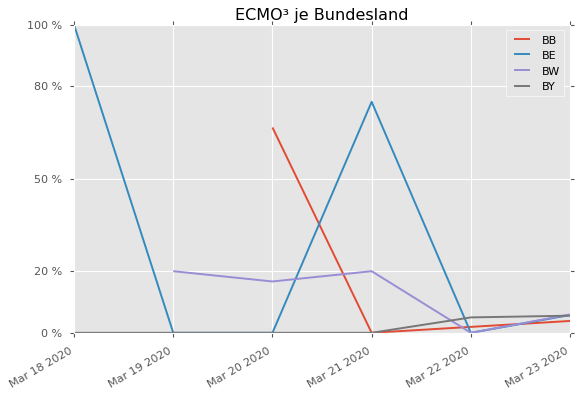

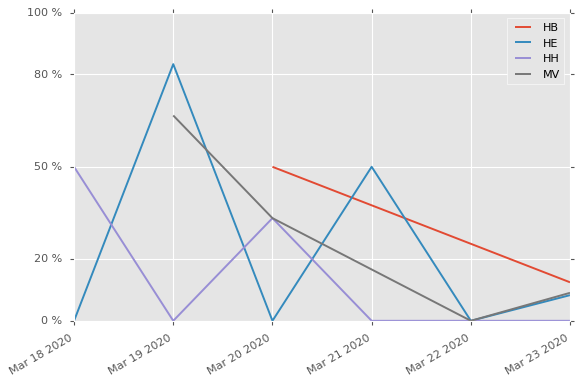

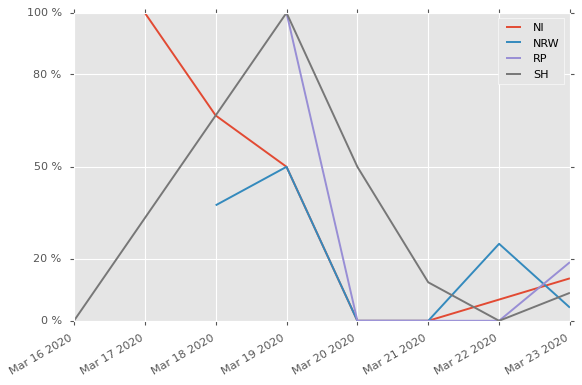

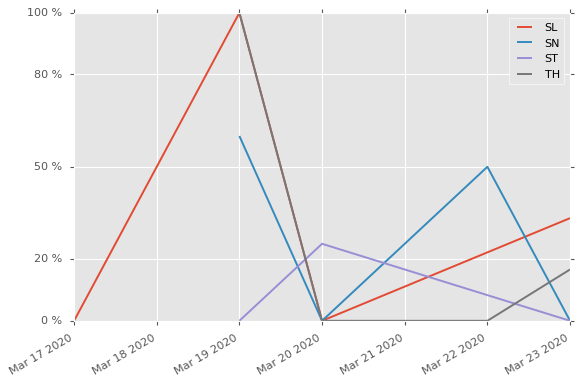

<Figure size 640x440 with 0 Axes>

In [739]:
plt.style.use('ggplot')
key = "ECMO³"
plt.title("%s je Bundesland" % key)
for offset in range(4):
    for land in sorted(set([x['Bundesland'] for x in clinics if x['Bundesland'] != '0']))[(offset*4):((offset+1)*4)]:
        ts = to_time_series([x for x in clinics if x['Bundesland'] == land and x['Stand'] > datetime.strptime("2019-12-31","%Y-%m-%d")],
                            'Stand', 
                            lambda r: 1)
        ts = to_time_series([x for x in clinics if x['Bundesland'] == land and x['Stand'] > datetime.strptime("2019-12-31","%Y-%m-%d")],
                            'Stand', 
                            lambda r: 1 if r[key]=='red' else (0.5 if r[key]=='yellow' else 0)) * 100 / ts
        ts.name = land
        ts.plot(legend=True)
    plt.yticks([0, 20, 50, 80, 100], ["0 %", "20 %", "50 %", "80 %", "100 %"])
    plt.figure()